In [1]:
import h5py
import numpy as  np
from pathlib import Path
import matplotlib.pyplot as plt
from source import helper
import matplotlib.image
import random
import datetime
import os
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["image.interpolation"] = 'none'
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense, Conv3D
from sklearn.model_selection import train_test_split

In [2]:
X = np.load('data/class/X(15, 15).npy')
X.shape

(81103, 6, 15, 15)

In [3]:
Y = np.load('data/class/Y(15, 15).npy')
Y.shape

(81103,)

In [4]:
Y = Y - 1

(array([13685., 14416., 15790., 13932., 23280.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

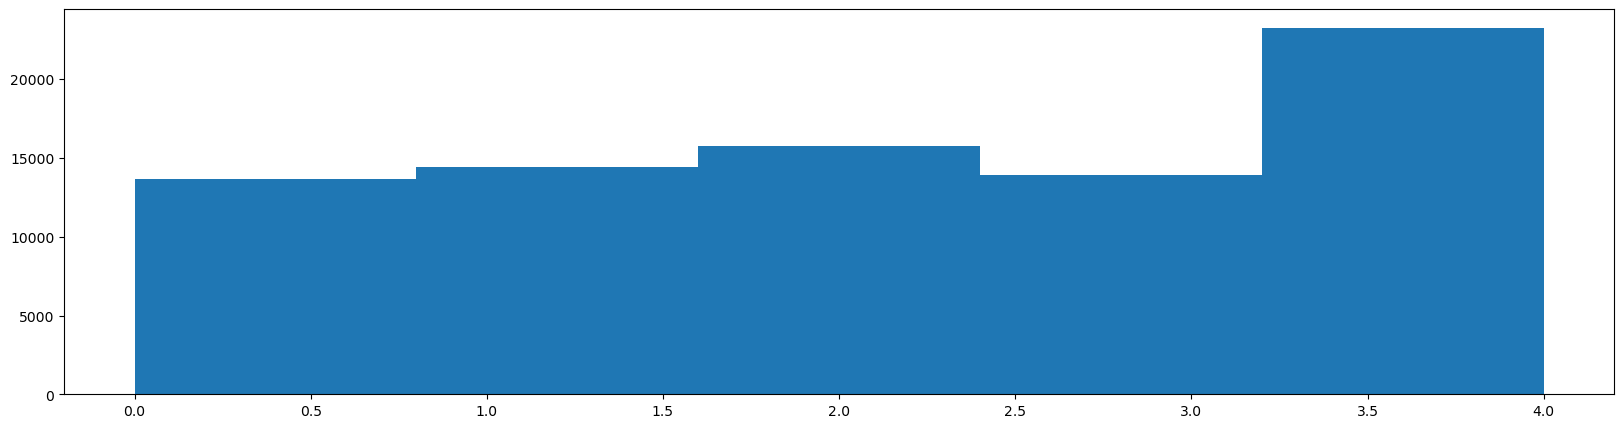

In [5]:
plt.hist(Y, bins=len(set(Y)))

In [6]:
%load_ext tensorboard
# do terminala: tensorboard --logdir data/logs_classification/fit

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [8]:
X_train  = np.array(X_train)
y_train = np.array(y_train)
X_test  = np.array(X_test)
y_test = np.array(y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [9]:
X_test.shape

(26764, 6, 15, 15, 1)

In [10]:
y_test.shape

(26764,)

In [11]:
model_name = 'class_conv3d_(15,15)'

input = Input((6,15,15,1))
x = Conv3D(8, (3,3,3))(input)
x = BatchNormalization()(x)
x = Conv3D(16, (3,3,3))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation = "relu")(x)
x = Dropout(0.4)(x)
x = Dense(5, activation = "softmax")(x)
classification_model = tf.keras.models.Model(input, x)

classification_model.compile(
  loss = "sparse_categorical_crossentropy",
  optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-6),
  metrics = ["accuracy"]
)
classification_model.summary()

log_dir = "data/logs_classification/fit" + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

with tf.device('/gpu:0'):
   classification_model.fit(X_train, y_train, batch_size = 32, epochs = 30,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

classification_model.save('data/models/'+model_name+'.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 15, 15, 1)]    0         
                                                                 
 conv3d (Conv3D)             (None, 4, 13, 13, 8)      224       
                                                                 
 batch_normalization (BatchN  (None, 4, 13, 13, 8)     32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 11, 11, 16)     3472      
                                                                 
 batch_normalization_1 (Batc  (None, 2, 11, 11, 16)    64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 2, 11, 11, 16)     0     

In [12]:
import pandas as pd
import seaborn as sn
from matplotlib.colors import LogNorm, Normalize
def display_cf_matrix(pred, y_test):
    prediciton = []
    for p in pred:
        prediciton.append(np.argmax(p))

    cf = tf.math.confusion_matrix(y_test, prediciton)

    df_cm = pd.DataFrame(cf, )
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='g', )

In [13]:
pred_X = classification_model.predict(X_test)

837/837 [==============================] - 2s 2ms/step


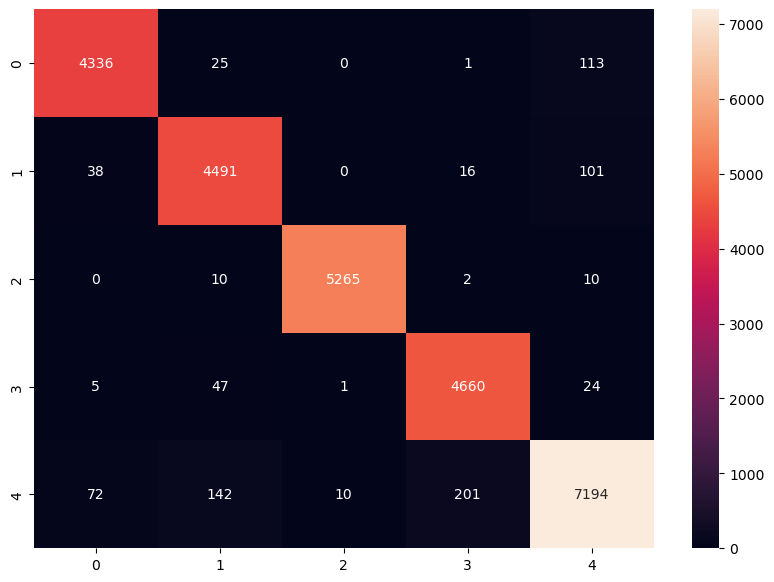

In [14]:
display_cf_matrix(pred_X, y_test)

- 0-bartek
- 1-kuba
- 2-oskar
- 3-rafal
- 4-oddychacz, wiatrak, samochod

In [15]:
X2 = np.expand_dims(X, axis=-1)
Y2 = np.expand_dims(Y, axis=-1)

2535/2535 [==============================] - 7s 3ms/step


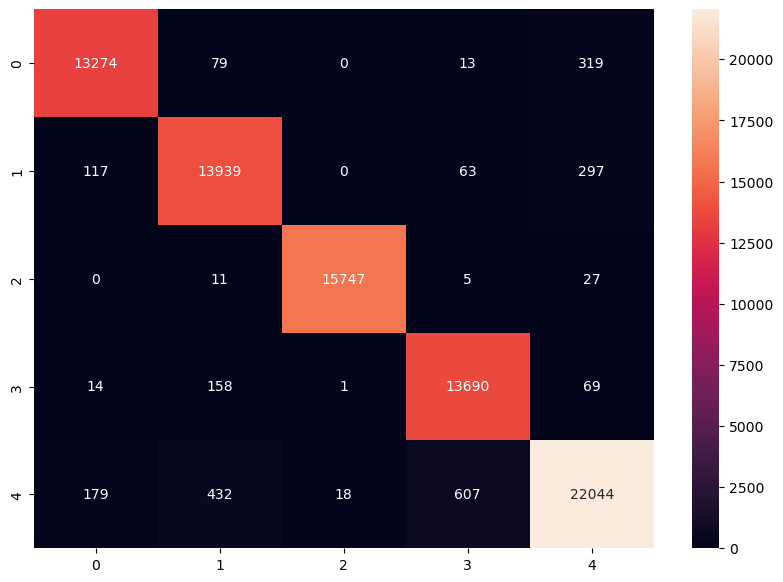

In [16]:
pred_X2 = classification_model.predict(X2)
display_cf_matrix(pred_X2, Y2)